In [ ]:
%matplotlib inline


# Neural network regression

In this example, we will train a classifier to distinguish between two classes, and evaluate the impact of the architecture and optimizer.

## Generating a dataset

We create a synthetic dataset. The true generative process will take a 1-D
vector and compute its sine.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
rng = np.random.RandomState(0)
X = np.random.randn(N,2)
Y = np.sign(X[:,0])*np.sign(X[:,1])
Y[Y==-1] = 0

Now, we can imagine a scenario where we get observations from this true
process. However, we will add some challenges:

- the measurements will be noisy;
- only samples from the beginning of the signal will be available.



# Dataloader
We first need to define a Torch dataset that encapsules our generative process. We can create a our custom dataset by inheriting from the class `torch.utils.data.dataset.Dataset`

In [ ]:
import torch
from torch.utils.data.dataset import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, target, n, noise_std=.05):
        training_sample_indices = rng.choice(np.arange(0, 400), size=n, replace=False)
        self.X = torch.Tensor(X[training_sample_indices,:] + noise_std * rng.randn(len(training_sample_indices),2)).type(torch.FloatTensor)
        self.Y = torch.Tensor(Y[training_sample_indices]).type(torch.LongTensor)

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])

    def __len__(self):
        return len(self.X)

Let's plot the true signal and the noisy measurements available for training.



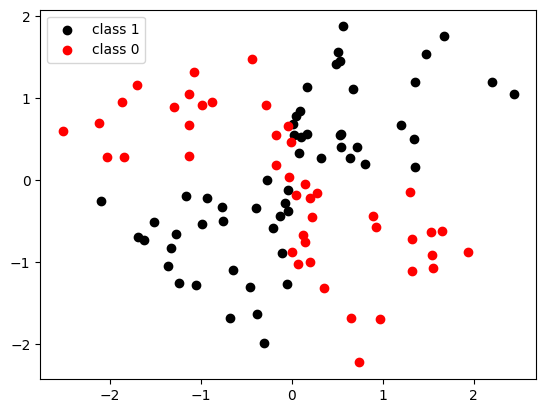

In [ ]:
dataset = CustomDataset(X, Y, n=100, noise_std=0)
plt.scatter(
    dataset.X[dataset.Y==1,0],
    dataset.X[dataset.Y==1,1],
    color="black",
    label="class 1",
)
plt.scatter(
    dataset.X[dataset.Y==0,0],
    dataset.X[dataset.Y==0,1],
    color="red",
    label="class 0",
)
plt.legend()

## Defining a neural network
First, we would like to highlight the limitations of a linear model given
our dataset. If we don't use any non-linear functions, the neural network can only learn a linear function. We start by defining the neural network function using the torch.nn.Module



Tensor Size:

[B, C, H, W]
where
B = size of minibatch
C = colours/channels
H = height of the image
W = width of the image

[B, C, D] where
B = size of minibatch
C = channels
D = length of the audio

in our example
[B, d] where
B = size of the minibatch
d = size of the input (=1)

In [ ]:
class LinearNet(torch.nn.Module):
    def __init__(self, hidden_features = 1000, classes=2):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, hidden_features)
        self.layer2 = torch.nn.Linear(hidden_features, classes)
        #self.softmax = torch.nn.Softmax()

    def forward(self, x):
        features = self.layer1(x)
        out = self.layer2(features)
        #out = self.softmax(out)
        return out.squeeze(1)


Training the network requires defining a dataloader `torch.utils.data.DataLoader`, an optimizer `torch.optim.SGD` and performing a loop over mini-batches of training data.
We'll do so and plot the training loss as a function of the epochs in order to make sure that we are actually minising the empirical risk!


Text(0, 0.5, 'training loss')

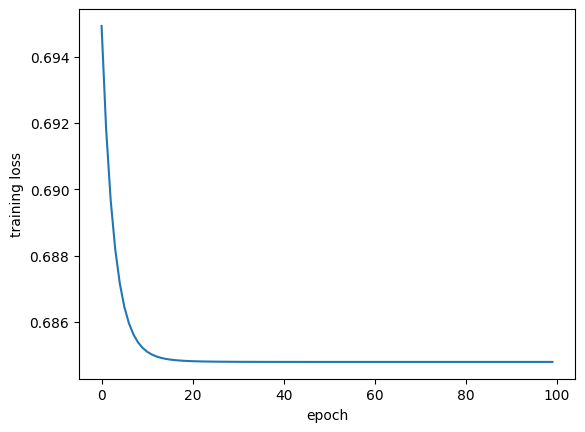

In [ ]:
net = LinearNet()

criterion = torch.nn.CrossEntropyLoss()
epochs = 100
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)

optimizer = torch.optim.SGD(net.parameters(), lr=.0001, weight_decay=0)

losses = []
for ep in range(epochs):
    err = []
    for i, (x,y) in enumerate(dataloader):
        xhat = net(x)
        loss = criterion(xhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        err.append(loss.item())

    losses.append(np.mean(err))

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("training loss")

Let's now inspect the learned (linear!) classifier

torch.Size([611964, 2])


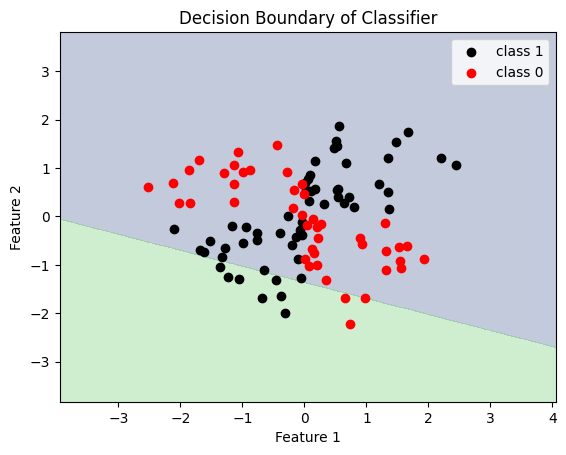

In [ ]:
# Define the range of values for the mesh grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Convert the mesh grid to PyTorch tensor
mesh_input = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Use your PyTorch model to predict the class for each point in the mesh grid
with torch.no_grad():
    net.eval()
    Z = net(mesh_input)
    print(Z.size())
    Z = (Z[:, 0] > Z[:, 1]).numpy()  # Convert to binary predictions

Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)

# Plot the data points
plt.scatter(
    dataset.X[dataset.Y==1,0],
    dataset.X[dataset.Y==1,1],
    color="black",
    label="class 1",
)
plt.scatter(
    dataset.X[dataset.Y==0,0],
    dataset.X[dataset.Y==0,1],
    color="red",
    label="class 0",
)
plt.legend()
# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary of Classifier')

# Show the plot
plt.show()

# Non-Linear Network

Let's now build and train a non-linear network by adding a relu activation.

In [ ]:
class NonLinearNet(torch.nn.Module):
    def __init__(self, hidden_features = 1000, classes=2):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, hidden_features)
        self.layer2 = torch.nn.Linear(hidden_features, classes)

    def forward(self, x):
        features = self.layer1(x)
        features = torch.nn.functional.relu(features)
        out = self.layer2(features)
        return out.squeeze(1)


Text(0, 0.5, 'training loss')

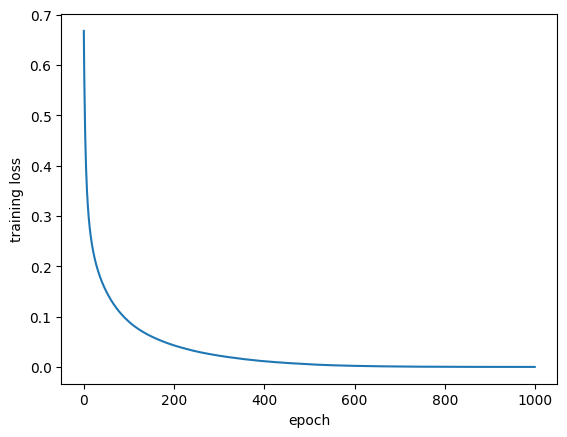

In [ ]:
net = NonLinearNet()

criterion = torch.nn.CrossEntropyLoss()
epochs = 1000
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

losses = []
for ep in range(epochs):
    err = []
    for i, (x,y) in enumerate(dataloader):
        loss = criterion(net(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        err.append(loss.item())

    losses.append(np.mean(err))

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("training loss")

torch.Size([611964, 2])


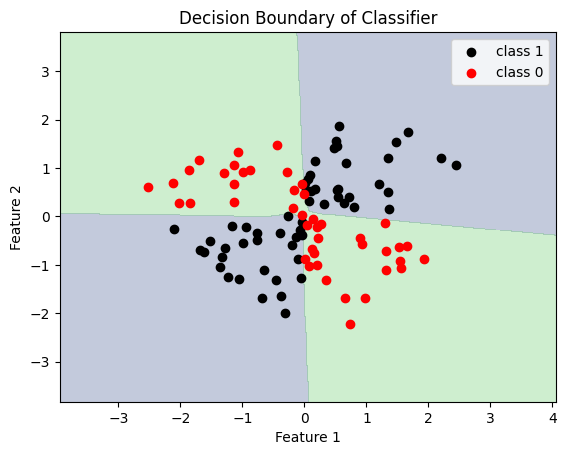

In [ ]:
# Use your PyTorch model to predict the class for each point in the mesh grid
with torch.no_grad():
    net.eval()
    Z = net(mesh_input)
    print(Z.size())
    Z = (Z[:, 0] > Z[:, 1]).numpy()  # Convert to binary predictions

Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)

# Plot the data points
plt.scatter(
    dataset.X[dataset.Y==1,0],
    dataset.X[dataset.Y==1,1],
    color="black",
    label="class 1",
)
plt.scatter(
    dataset.X[dataset.Y==0,0],
    dataset.X[dataset.Y==0,1],
    color="red",
    label="class 0",
)
plt.legend()
# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary of Classifier')

# Show the plot
plt.show()

# TODO List

* Change the optimizer to Adam and tune the hyperparameters
* Increase the noise to .05 and reduce the number of datapoints
* Evaluate the effect of the width of the network
* Add more classes (4 classes)
* Build a deeper network